In [17]:
import os
import sys
import numpy as np


import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


ALLDIR='/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4'
BASEDIR = "/home/lachlan/"
TIFDIR = "DATA/datasets/XFMDATA/Zoe/slides_99um/s4"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4
['/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Al.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-As.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Ca.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Cl.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Cr.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Cu.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Fe.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-K.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Mg.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s4/full_99um_s4_cali-Mn.tiff', '/home/lachlan/DA

Epochs completed:   0%|            0/200 [00:00]

Thu Apr 20 23:01:39 2023 Finished embedding
RUNNING CLUSTERING
RUNNING CLUSTERING
DBSCAN PARAM 0.0001, 0.0001
cluster 0, count: 2771
cluster 1, count: 30219
cluster 2, count: 10281
cluster 3, count: 6025
-----Na tracker: 0.10000000149011612
(60912, 18)
Mg
0.0 0.012337300926446915 0.03400409482419491


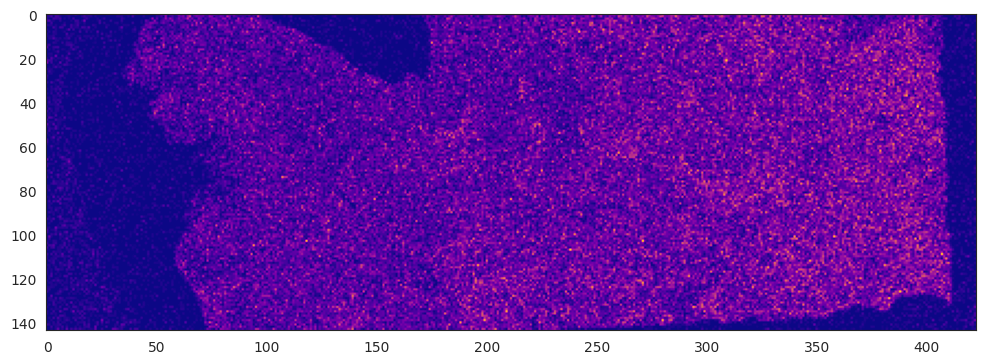

6
(60912,)
0
1


/home/lachlan/CODEBASE/ReadoutXFM/notebooks/../xfmreadout/processed_plots.py:166: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


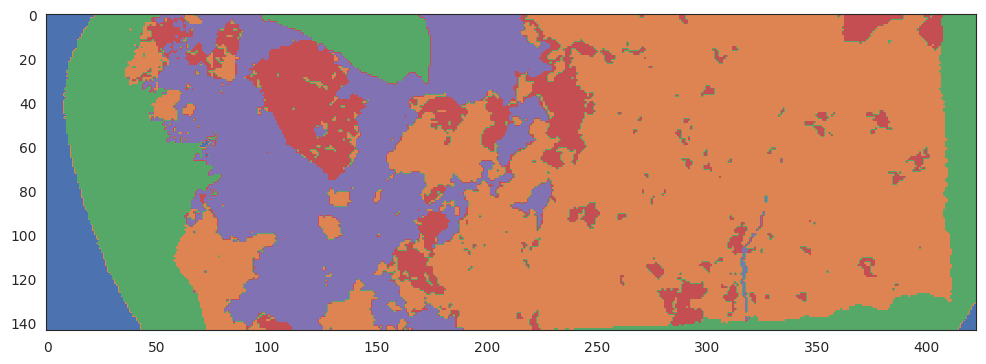

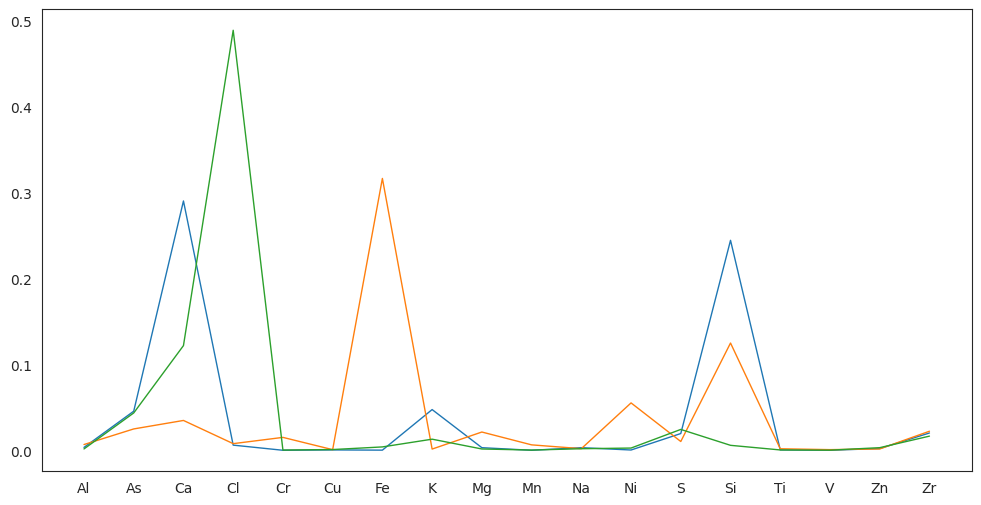

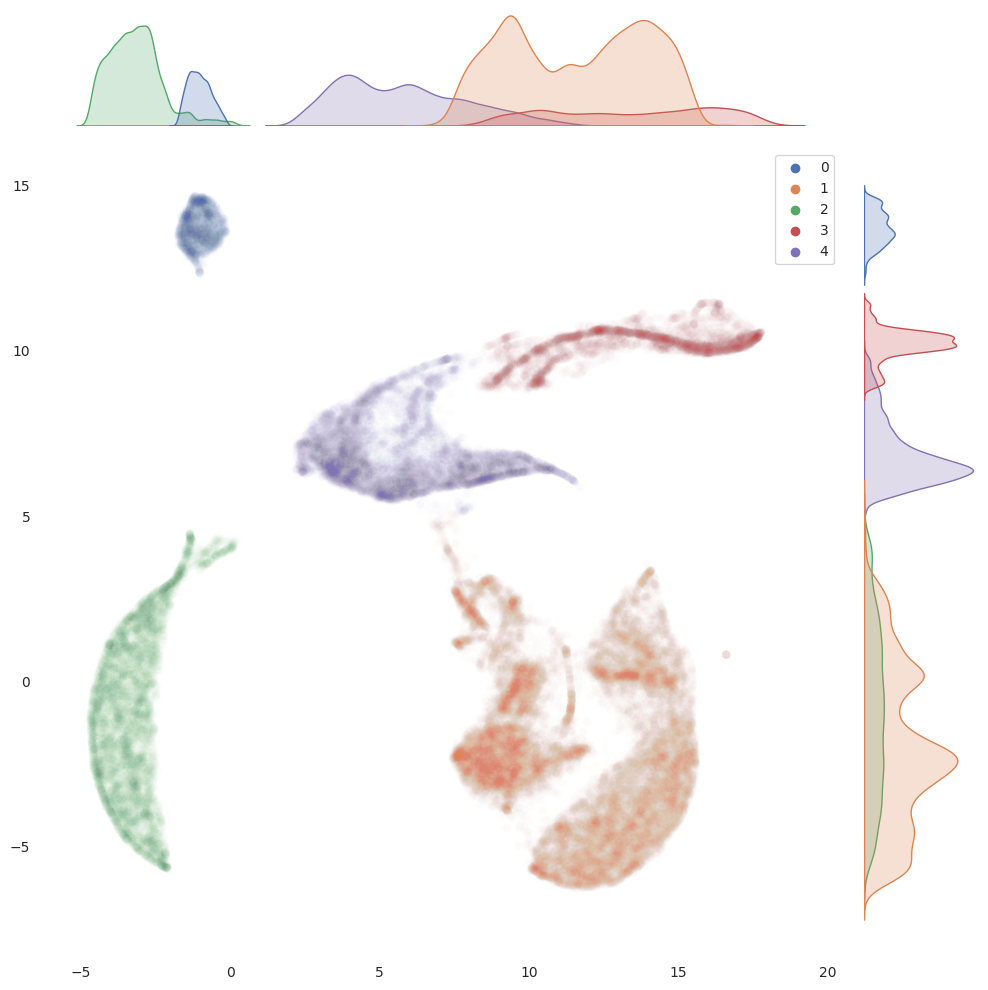

Al, max: 0.50, 98: 0.06, avg: 0.01
As, max: 0.09, 98: 0.06, avg: 0.03
Ca, max: 1.23, 98: 0.96, avg: 0.14
Cl, max: 0.89, 98: 0.60, avg: 0.09
Cr, max: 1.60, 98: 0.04, avg: 0.01
Cu, max: 0.79, 98: 0.01, avg: 0.00
Fe, max: 5.97, 98: 0.45, avg: 0.17
K, max: 0.10, 98: 0.05, avg: 0.01
Mg, max: 0.10, 98: 0.05, avg: 0.02
Mn, max: 0.12, 98: 0.01, avg: 0.00
Na, max: 0.10, 98: 0.01, avg: 0.00
Ni, max: 6.57, 98: 0.42, avg: 0.08
S, max: 0.84, 98: 0.09, avg: 0.01
Si, max: 1.00, 98: 0.25, avg: 0.11
Ti, max: 0.05, 98: 0.01, avg: 0.00
V, max: 0.03, 98: 0.00, avg: 0.00
Zn, max: 0.04, 98: 0.01, avg: 0.00
Zr, max: 0.73, 98: 0.10, avg: 0.02


In [69]:
%load_ext autoreload
%autoreload 2

import xfmreadout.processed_ops as processed_ops

FORCE=True

data, elements, dims = processed_ops.get_data(image_directory)


print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")
categories, classavg, embedding, clusttimes, data, dims = processed_ops.process(data, dims, image_directory, force=FORCE)
print(f"-----{elements[10]} tracker: {np.max(data[:,10])}")

processed_ops.plot_all(categories, classavg, embedding, data, elements, dims)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





In [27]:
print(max(data[10]))
print(elements[10])

0.93018293
Na


In [142]:
print(np.max(categories), np.min(categories))
classavg.shape

15 -1


(16, 19)